# Colima Inversion Examples



In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df = pd.read_csv(filename)

phi_labels = [
    "[-5,-4)",
    "[-4,-3)" ,
    "[-3,-2)",
    "[-2,-1)",
    "[-1,0)",
    "[0,1)",
    "[1,2)",
    "[2,3)",
    "[3,4)"
]

ventx = 645110
venty = 2158088

raw_df["Easting"] = raw_df["Easting"] - ventx
raw_df["Northing"] = raw_df["Northing"] - venty

for phi in phi_labels:
    raw_df[phi] = (raw_df[phi].values)*100
    
raw_df["radius"] = np.sqrt(raw_df["Easting"]**2 + raw_df["Northing"]**2)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
0,VF95-06a,3133,9522,417.20,40,0.0,11.0,21.0,22.0,23.0,17.0,4.0,0.0,0.0,10024.179418
1,VF95-08a,1907,8096,312.90,30,1.0,13.0,19.0,24.0,25.0,16.0,3.0,0.0,0.0,8317.563646
2,VF97-20Q,5500,8723,208.60,20,2.0,7.0,14.0,21.0,26.0,21.0,6.0,1.0,1.0,10312.164128
3,VF98-01a3,2665,9054,239.89,23,4.0,13.0,18.0,21.0,23.0,15.0,3.0,0.0,0.0,9438.068711
4,VF98-02a,1154,7735,156.45,15,1.0,12.0,19.0,23.0,24.0,17.0,3.0,0.0,0.0,7820.610015


## Preprossessing Steps

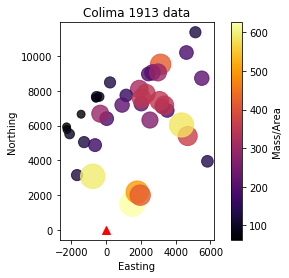

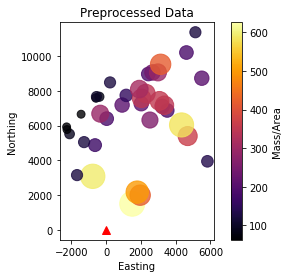

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()
obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)

obs_df = obs_df.sort_values(by=['radius'])\

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

# Uncomment to drop proximal points
# obs_df = obs_df[obs_df["radius"]>3500]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid = obs_df[["Easting", "Northing"]].copy()
grid["Elevation"] = np.zeros(len(grid))
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# Order of these 3 commands matter
t2_df["radius"] = np.sqrt(t2_df["Easting"]**2 + t2_df["Northing"]**2)
t2_df = t2_df.sort_values(by=['radius'])
t2_df["Residual"] = t2_df["MassArea"]/obs_df["MassArea"]*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,833.032,17.3819,20.9560,20.9332,17.7376,12.6550,6.92374,2.59392,0.692536,0.126138,2124.861643,133.114733
18,1957,1997,0,695.129,17.3999,21.2760,20.9644,17.4749,12.3856,6.83364,2.73539,0.781439,0.148918,2796.043276,166.617689
17,1787,2173,0,694.558,17.5614,21.4823,21.1019,17.4671,12.2469,6.65295,2.61205,0.736269,0.139112,2813.413940,138.734020
37,-770,3082,0,227.391,14.1129,18.5440,20.7423,19.3846,14.6875,8.27902,3.20274,0.881546,0.165408,3176.731654,38.248474
31,-1673,3152,0,100.136,11.3118,15.5037,19.2828,20.3236,17.0715,10.53570,4.42227,1.293020,0.255589,3568.477687,80.006392


In [5]:
config = {}
with open("data/colima/colima_config.txt") as f:
    for line in f:
        line = line.strip()
        if not line=="" and not line.startswith("#"):
            (key, val) = line.split()
            config[str(key)] = float(val)

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}



# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 645110.0,
 'VENT_NORTHING': 2158088.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0


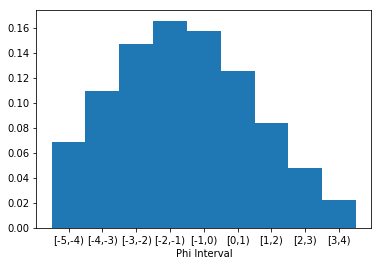

In [6]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps).head())



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [7]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(config, globs, grid,
                                                          int(config["COL_STEPS"]), 0, 
                                                          config["PLUME_HEIGHT"], 
                                                          q_dist,
                                                          mass_in_phi, 
                                                          (u,v), 
                                                          phi_step["lower"], 
                                                          phi_step["density"])
    
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))

elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge
forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"]/obs_df["MassArea"]*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.03125 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.07812 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,14.662719,21.477998,23.539136,19.738045,12.911090,6.004510,1.483327,0.176485,0.006689,1198.607874,2124.861643,287.298148
1,1997,1957,12.230719,20.077097,23.726699,20.663027,13.960236,6.966140,2.072407,0.291357,0.012318,1005.835755,2796.043276,321.455978
2,2173,1787,12.123985,20.006264,23.736202,20.718095,14.012231,7.001938,2.093069,0.295676,0.012540,1024.563441,2813.413940,491.161765
3,3082,-770,12.554313,20.438257,23.932389,20.448488,13.450774,6.659616,2.162336,0.338322,0.015505,404.939158,3176.731654,168.802017
4,3152,-1673,12.594545,20.611603,24.181124,20.493127,13.155693,6.344995,2.210467,0.388875,0.019571,193.246416,3568.477687,123.519601


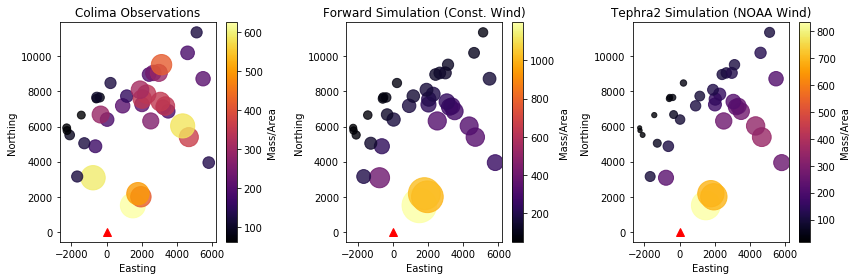

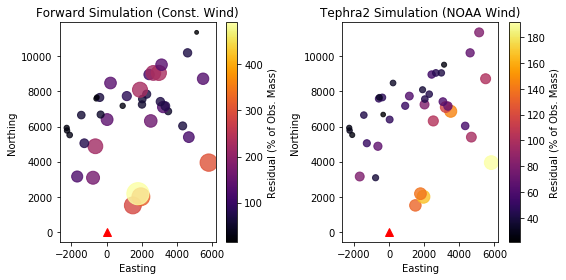

In [8]:
fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[2])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(
        8,4), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(forward_df, vent=(0,0), log=False, values="Residual",
            title="Forward Simulation (Const. Wind)", cbar_label="Residual (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_df, vent=(0,0), log=False, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Residual (% of Obs. Mass)", ax=axs[1])


plt.tight_layout()
plt.show()

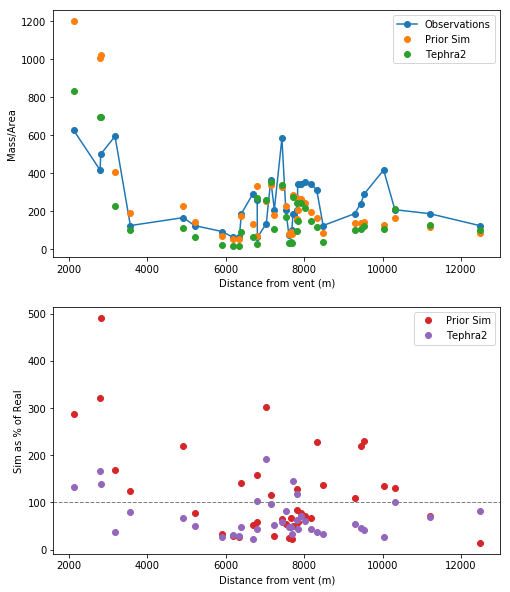

In [9]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()


axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Prior Sim")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C2o', label="Tephra2")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C3o', label="Prior Sim")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C4o', label="Tephra2")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
a* = -3.77439	b* = -0.60764            	h0* = -1.52718	h1* = 1.50153
a = 1.02295	b = 1.54464	h0 = 0.01000	h1 = 24008.52670
Success: True, Optimization terminated successfully.
Iterations: 108
SSE: 0.5214217642738253


,Height,Suspended Mass
0,1200.0,4.125107e+09
1,2400.0,4.069682e+09
2,3600.0,3.981876e+09
3,4800.0,3.878124e+09
4,6000.0,3.763461e+09
5,7200.0,3.639936e+09
6,8400.0,3.508412e+09
7,9600.0,3.369144e+09
8,10800.0,3.221999e+09
9,12000.0,3.066528e+09


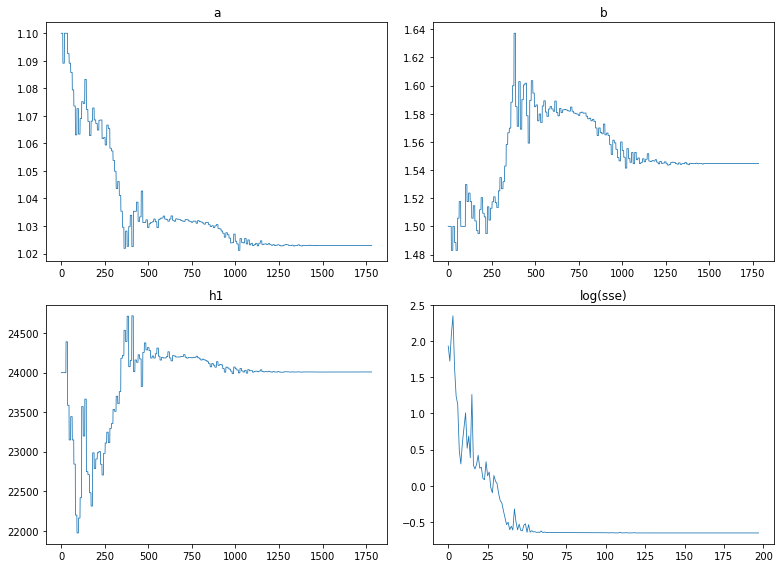

========NOAA Wind Simulation========
a* = -2.14503	b* = -2.55914            	h0* = -1.52718	h1* = 1.80803
a = 1.11706	b = 1.07737	h0 = 0.01000	h1 = 25462.83762
Success: True, Optimization terminated successfully.
Iterations: 83
SSE: 304.1133434200876


,Height,Suspended Mass
0,1200.0,2.288876e+09
1,2400.0,2.472624e+09
2,3600.0,2.582122e+09
3,4800.0,2.658924e+09
4,6000.0,2.716691e+09
5,7200.0,2.761666e+09
6,8400.0,2.797207e+09
7,9600.0,2.825290e+09
8,10800.0,2.847135e+09
9,12000.0,2.863489e+09


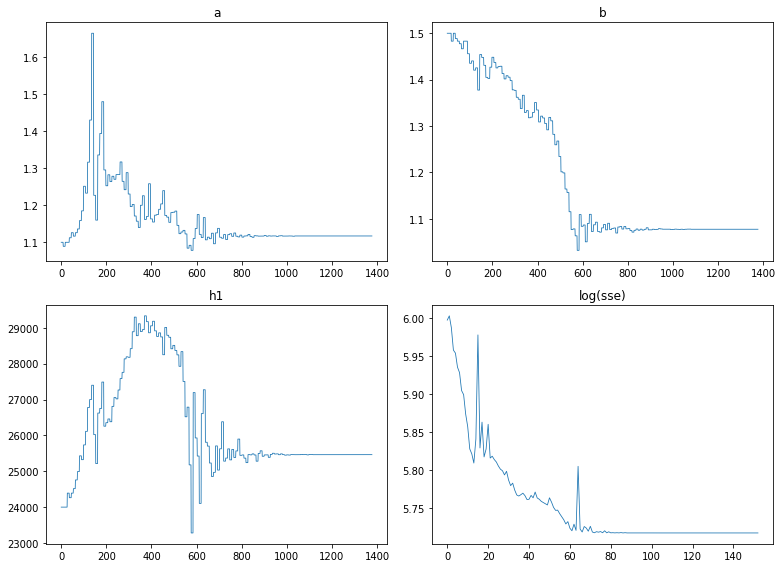

========Observation Data========
a* = -1.68315	b* = -2.26544            	h0* = -1.52718	h1* = 1.74190
a = 1.18579	b = 1.10378	h0 = 0.01000	h1 = 25179.01801
Success: True, Optimization terminated successfully.
Iterations: 75
SSE: 620.0656063619326


,Height,Suspended Mass
0,1200.0,2.024414e+09
1,2400.0,2.290409e+09
2,3600.0,2.455780e+09
3,4800.0,2.575269e+09
4,6000.0,2.667423e+09
5,7200.0,2.740883e+09
6,8400.0,2.800366e+09
7,9600.0,2.848685e+09
8,10800.0,2.887587e+09
9,12000.0,2.918155e+09


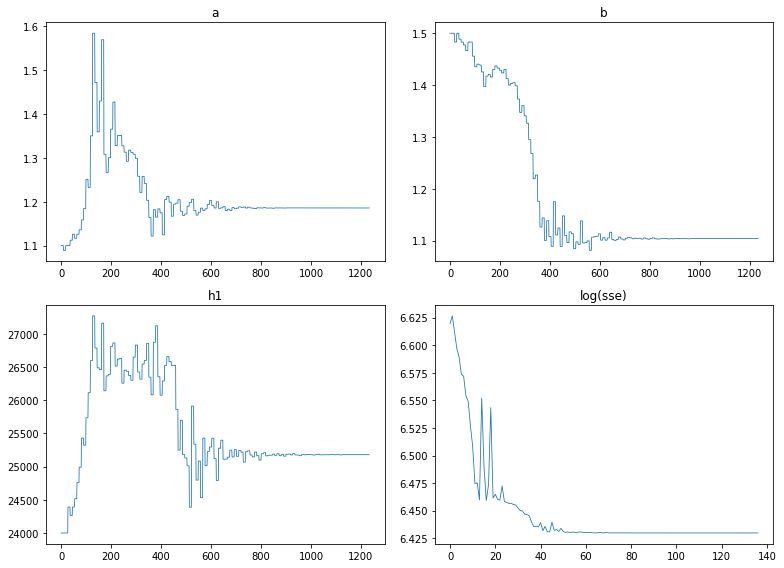

In [10]:
priors_vals = {
    "a": 1.1,
    "b": 1.5,
    "h0": 0.01,
    "h1": 24000
}

invert_params = {
        "a" : True,
        "b" : True,
        "h0" : False,
        "h1" : True
    }

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Const. Wind Simulation", "NOAA Wind Simulation", "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_inversion(config, 
                              globs, df, 
                              len(df), 
                              20, 0, 
                              config["PLUME_HEIGHT"], 
                              config["ERUPTION_MASS"],
                              (u,v),
                              phi_steps,
                              invert_params=invert_params,
                              priors = priors_vals, 
                              column_cap=H)
    inversion_table, _, _, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,3], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



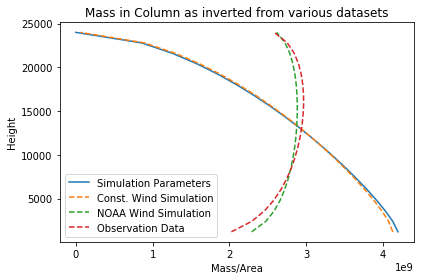

In [11]:
fig, ax1 = plt.subplots(1,1, figsize=(
    6, 4), facecolor='w', edgecolor='k')

    

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(q_dist, 0, 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"], 
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Const. Wind Simulation========


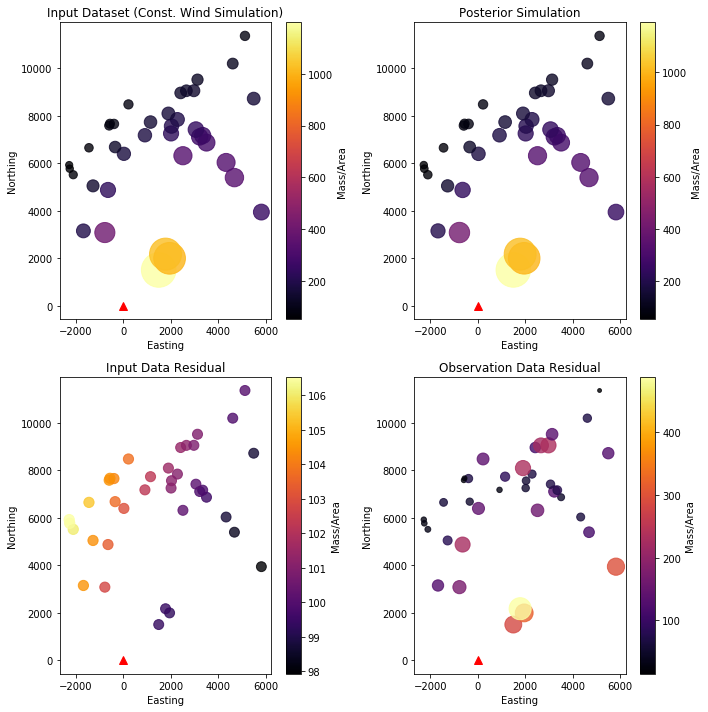

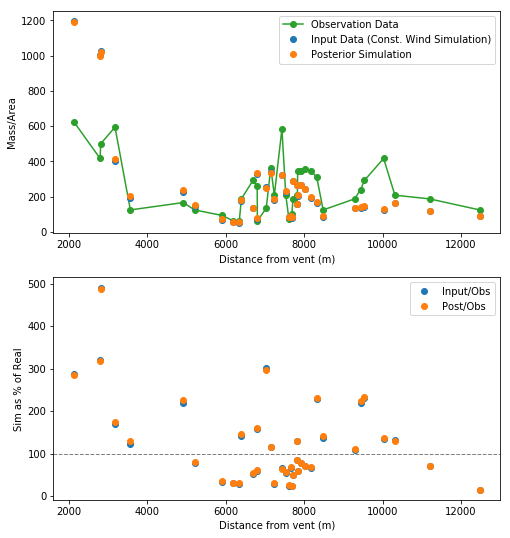

========NOAA Wind Simulation========


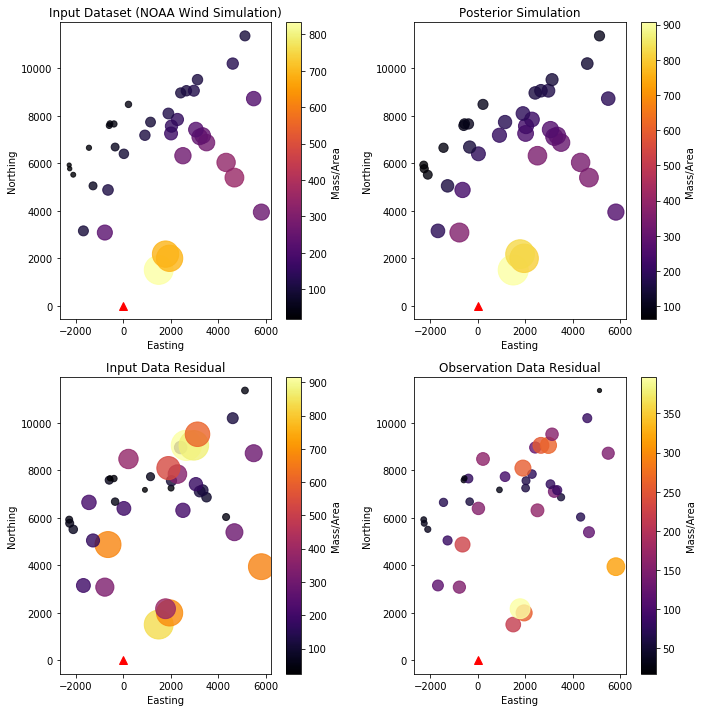

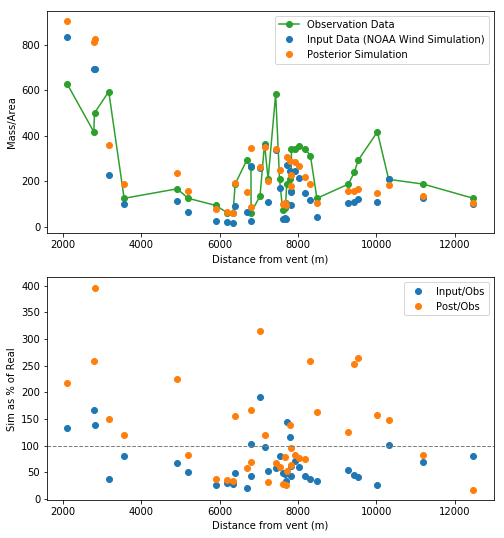

========Observation Data========


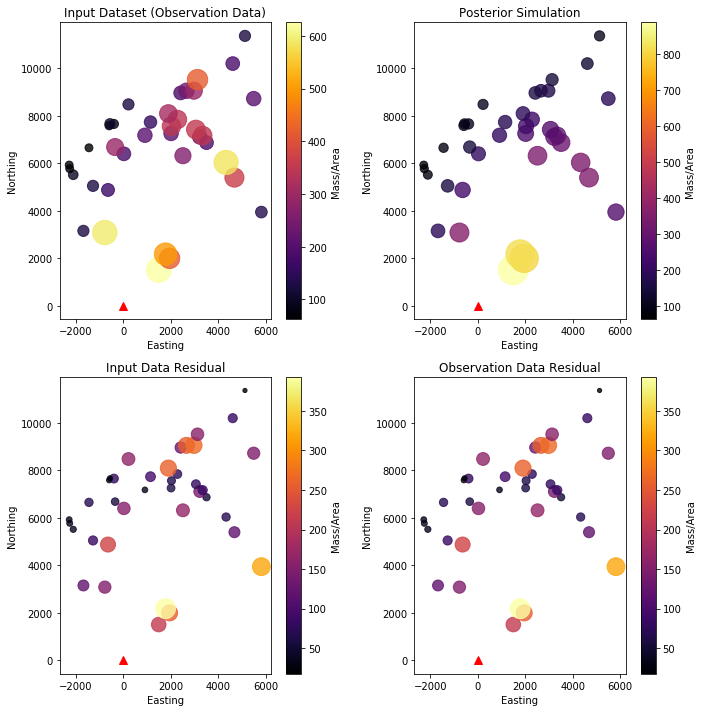

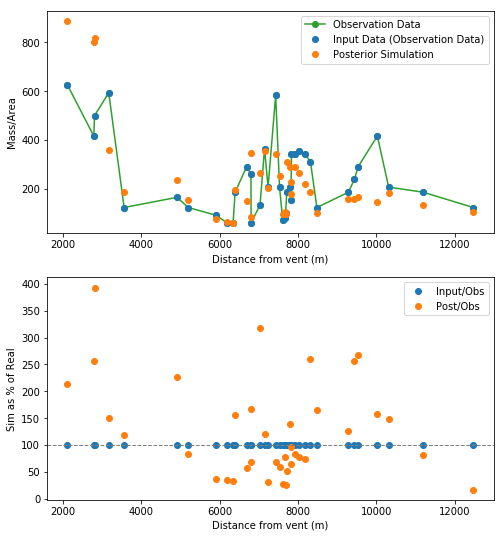

In [12]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        config, globs, grid, int(config["COL_STEPS"]), 0, 
        params["h1"], phi_steps, q_dist, config["ERUPTION_MASS"], (u,v)
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"]/obs_df["MassArea"]*100
    post_df["Change"] = post_df["MassArea"]/in_data["MassArea"]*100
    
    fig, axs = plt.subplots(2,2, figsize=(
            10, 10), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Change",
                title="Input Data Residual", cbar_label="Mass/Area", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Residual",
                title="Observation Data Residual", cbar_label="Mass/Area", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [13]:
# fig, axs = plt.subplots(2,1, figsize=(
#         8, 9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs[0].plot(obs_df["radius"].values, rotdf["MassArea"].values, 'C0-', label="Obs")
# axs[0].plot(df_merge["radius"].values, df_merge["MassArea"].values, 'C1-', label="Prior")
# axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C2-', label="Post")
# axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3-', label="T2")
# axs[0].legend()
# axs[0].set_xlabel("Distance from vent (m)")
# axs[0].set_ylabel("Mass/Area")


# axs[1].plot(prior_res_obs["radius"].values, prior_res_obs["MassArea"].values, 'C1-', label="Prior/Obs")
# axs[1].plot(post_res_obs["radius"].values, post_res_obs["MassArea"].values, 'C2-', label="Post/Obs")
# axs[1].plot(t2_res_df["radius"].values, t2_res_df["MassArea"].values, 'C3-', label="T2/Obs")
# axs[1].legend()
# axs[1].set_xlabel("Distance from vent (m)")
# axs[1].set_ylabel("Residual (%)")
# plt.show()

========Const. Wind Simulation========
a* = -2.54241	b* = -0.02366	            h0* = -1.52718	h1* = 0.74354	u* = 1.74622	v* = 2.10351
a = 1.07868	b = 1.97662	            h0 = 0.01000	h1 = 27972.83081	u = 5.73290	v = 8.19487
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 633
SSE: 0.0844585635686415


,Height,Suspended Mass
0,1200.0,4.107518e+09
1,2400.0,4.147763e+09
2,3600.0,4.085860e+09
3,4800.0,3.978315e+09
4,6000.0,3.843888e+09
5,7200.0,3.691309e+09
6,8400.0,3.525412e+09
7,9600.0,3.349172e+09
8,10800.0,3.164563e+09
9,12000.0,2.972962e+09


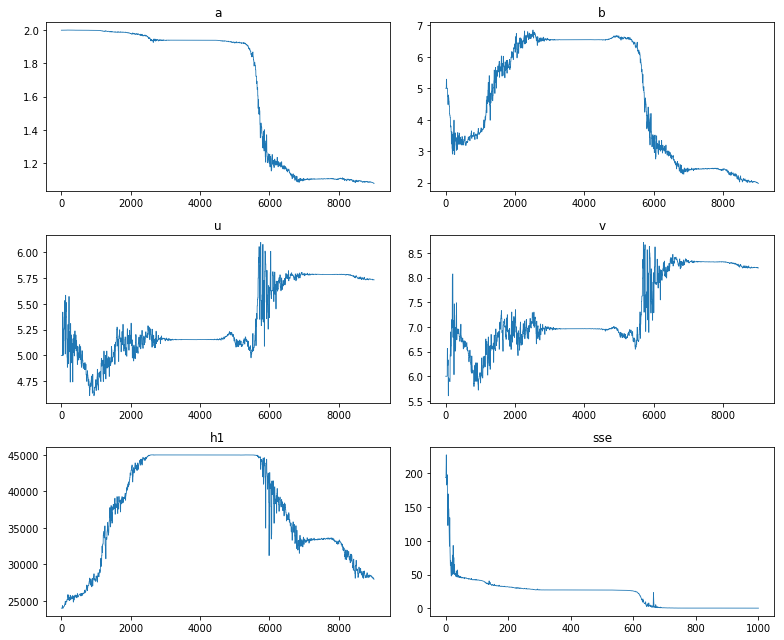

Const. Wind Simulation Run Time: 166.90625 seconds


========NOAA Wind Simulation========
a* = -3.96314	b* = -1.30740	            h0* = -1.52718	h1* = 1.40434	u* = 2.02090	v* = 2.13070
a = 1.01900	b = 1.27052	            h0 = 0.01000	h1 = 35203.04107	u = 7.54508	v = 8.42072
Success: True, Optimization terminated successfully.
Iterations: 561
SSE: 135.83193890871672


,Height,Suspended Mass
0,1200.0,2.982912e+09
1,2400.0,2.993229e+09
2,3600.0,2.986124e+09
3,4800.0,2.971215e+09
4,6000.0,2.951512e+09
5,7200.0,2.928327e+09
6,8400.0,2.902326e+09
7,9600.0,2.873868e+09
8,10800.0,2.843146e+09
9,12000.0,2.810247e+09


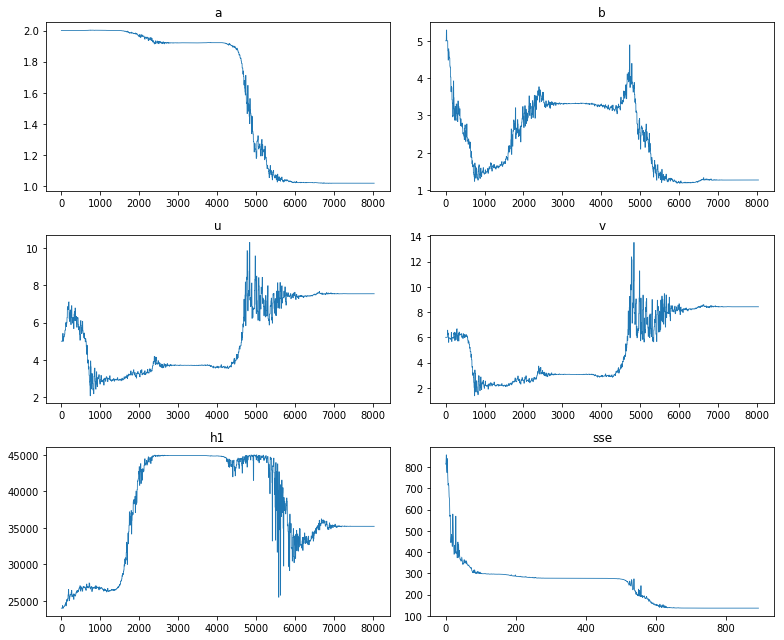

NOAA Wind Simulation Run Time: 163.31250 seconds


========Observation Data========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:306: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = -2.22249	b* = -2.14828	            h0* = -1.52718	h1* = 1.07991	u* = 1.85071	v* = 2.61903
a = 1.10834	b = 1.11668	            h0 = 0.01000	h1 = 32041.61592	u = 6.36432	v = 13.72239
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 626
SSE: 530.7546420678252


,Height,Suspended Mass
0,1200.0,2.323939e+09
1,2400.0,2.493603e+09
2,3600.0,2.593049e+09
3,4800.0,2.661718e+09
4,6000.0,2.712553e+09
5,7200.0,2.751478e+09
6,8400.0,2.781698e+09
7,9600.0,2.805130e+09
8,10800.0,2.822994e+09
9,12000.0,2.836093e+09


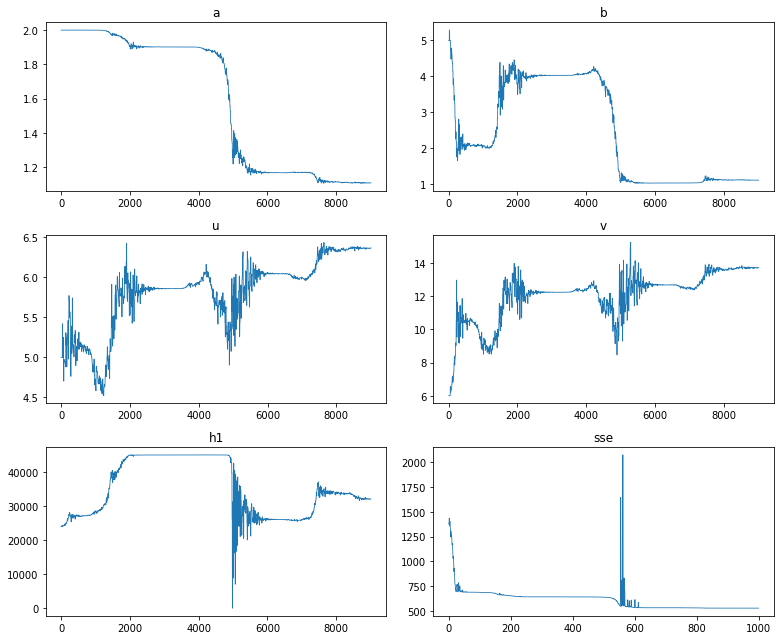

Observation Data Run Time: 176.32812 seconds


Total Run Time: 506.54688 seconds


In [14]:
priors_vals = {
    "a": 2,
    "b": 5,
    "h0": 0.01,
    "h1": 24000,
    "u": 5,
    "v": 6
}

invert_params = {
    "a" : True,
    "b" : True,
    "h0" : False,
    "h1" : True,
    "u": True,
    "v": True
}

H = 45000
t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Const. Wind Simulation", "NOAA Wind Simulation", "Observation Data"]
data_sets = [forward_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_wind_inversion(config, 
                                      globs, df, 
                                      len(df), 
                                      20, 0, 
                                      config["PLUME_HEIGHT"], 
                                      config["ERUPTION_MASS"], 
                                      phi_steps,
                                      invert_params = invert_params,
                                      priors=priors_vals,
                                      column_cap=H)
    inversion_table, params, sol, sse, trace, wind_trace, sse_trace = out
    params_no_wind = list(params.values())
    params_no_wind = params_no_wind[:-2]
    
    inv_mass, _, _, _, _ = beta_transform(*param_inv_transform(*params_no_wind, H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    wind_trace = np.array(wind_trace)
    fig, axs = plt.subplots(3,2, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(wind_trace[:,0], linewidth=.8)
    axs[2].set_title("u")

    axs[3].plot(wind_trace[:,1], linewidth=.8)
    axs[3].set_title("v")


    axs[4].plot(trace[:,3], linewidth=.8)
    axs[4].set_title("h1")

    axs[5].plot(sse_trace, linewidth=.8)
    axs[5].set_title("sse")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f seconds\n\n"%(name, run_time))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f seconds"%(total_run_time))

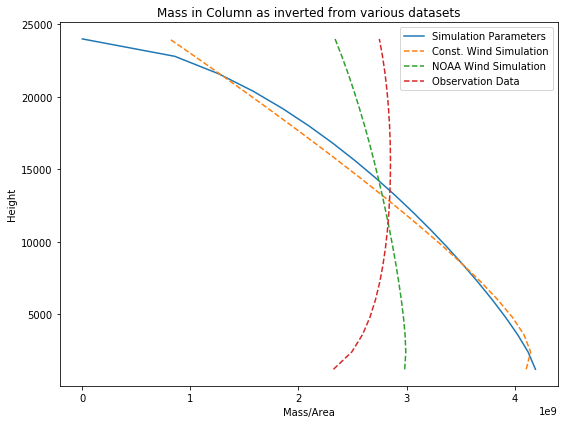

In [15]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(q_dist, 0, 
                            config["PLUME_HEIGHT"], 
                            inversion_table["Height"], 
                            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Const. Wind Simulation========


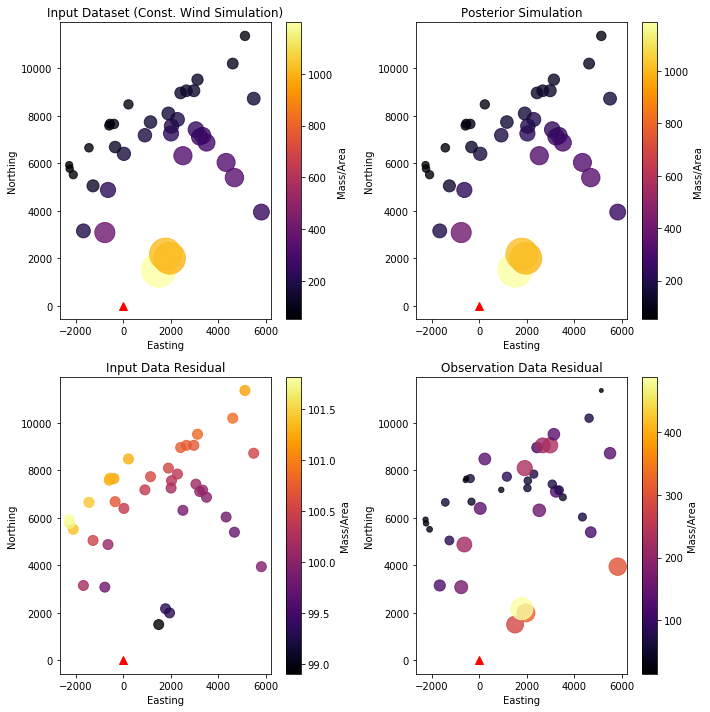

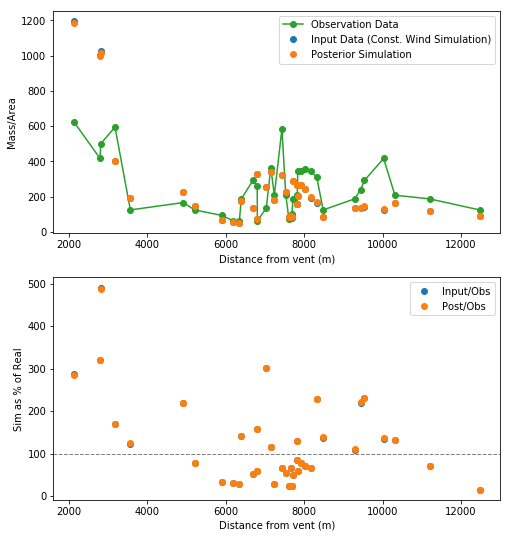

========NOAA Wind Simulation========


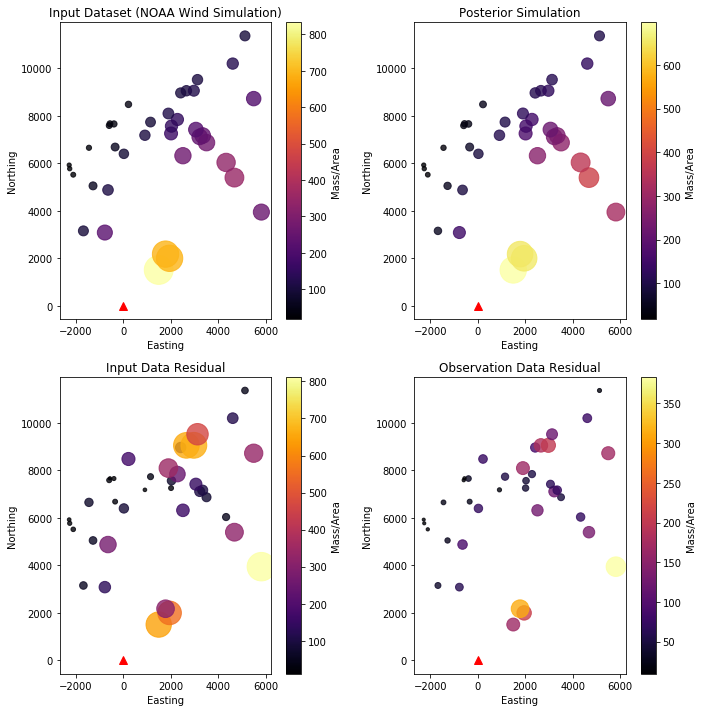

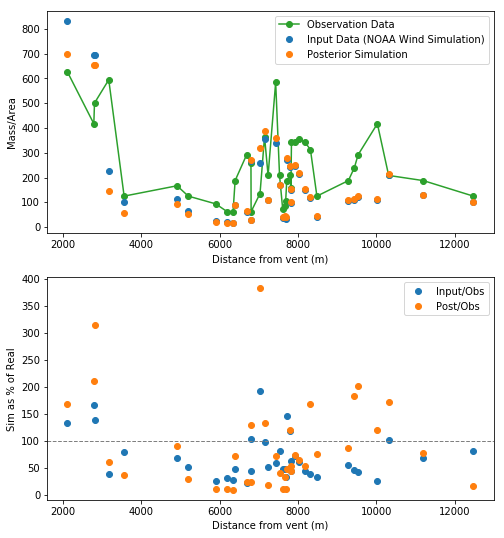

========Observation Data========


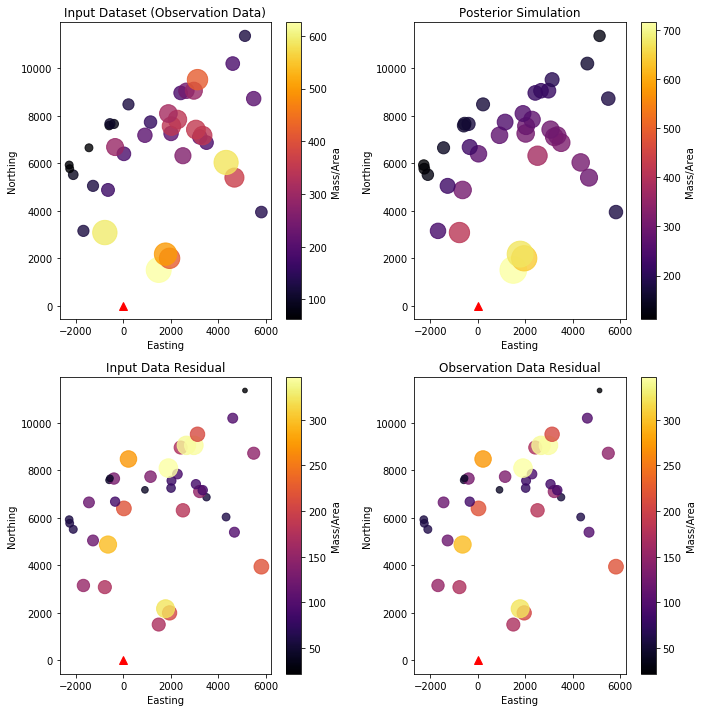

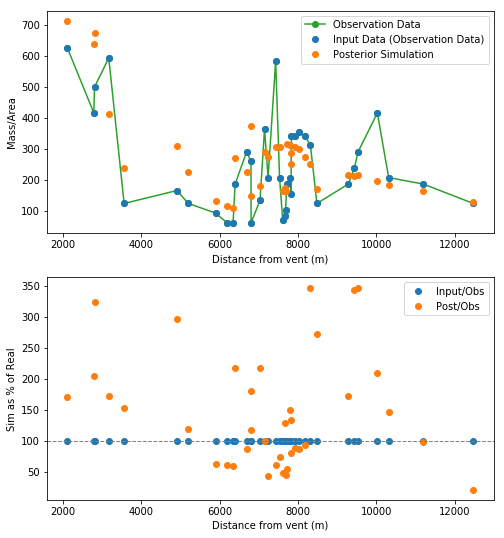

In [16]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]
    u = params["u"]
    v = params["v"]
    post_df = gaussian_stack_forward(
        config, globs, grid, int(config["COL_STEPS"]), 0, 
        params["h1"], phi_steps, q_dist, config["ERUPTION_MASS"], (u,v)
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"]/obs_df["MassArea"]*100
    post_df["Change"] = post_df["MassArea"]/in_data["MassArea"]*100
    
    fig, axs = plt.subplots(2,2, figsize=(
            10, 10), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Change",
                title="Input Data Residual", cbar_label="Mass/Area", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Residual",
                title="Observation Data Residual", cbar_label="Mass/Area", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    